## Image Browser

This example shows how to browse through a set of images with a slider.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
import os
from pydicom import dicomio
import numpy as np
plt.rcParams['figure.figsize'] = (10.0, 8.0)

We will use the digits dataset from [scikit-learn](http://scikit-learn.org/stable/).

In [2]:
"""
Created on Wed Jun 24 22:54:15 2015

@author: sansomk

based on the following
http://cmic.cs.ucl.ac.uk/fileadmin/cmic/Documents/DavidAtkinson/DICOM_6up.pdf
"""

class StandardOrientationException(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

def bipedCheck(iminfo):
    """
    If Anatomical Orientation Type (0010,2210) is absent or has a value
    of BIPED, the x-axis is increasing to the left hand side of the patient.
    The y-axis is increasing to the posterior side of the patient.
    The z-axis is increasing toward the head of the patient.
    @param dicom data iminfo contains image info

    """
    #check coordinate system
    biped = False
    if((0x0010, 0x2210) in iminfo.keys()):
        axis_str = iminfo[(0x0010, 0x2210)]
        if(axis_str == "BIPED"):
              biped = True
        else:
              print("something weird with coordinate sys")
    else:
        biped = True

    if( biped == False):
        raise StandardOrientationException("not using standard axes")
    # add the standard axes here
    return


def transformMatrix(iminfo):
    """
    This function calculates the 4x4 transform matrix from the image
    coordinates to patient coordinates.
    """
    dt = np.float64 
    # converts strings to doubles
    # image position patient  
    ipp = np.array(iminfo.ImagePositionPatient, dtype=dt)
    #image orientation patient  
    iop = np.array(iminfo.ImageOrientationPatient, dtype=dt)
    #print("ipp", ipp)
    #print("iop", iop)
    # pixel spacing
    ps = np.array(iminfo.PixelSpacing, dtype=dt)

    #check it whether image has been interpolated
    if (hasattr(iminfo, 'SpacingBetweenSlices')):
        if(iminfo.SpacingBetweenSlices < iminfo.SliceThickness):
            z_spac = iminfo.SpacingBetweenSlices
        else:
            z_spac = iminfo.SliceThickness
    else:
        z_spac= iminfo.SliceThickness

    #print("z_spac", z_spac)
    z_spacing = dt(z_spac)
    #Translate to put top left pixel at ImagePositionPatient
    Tipp = np.array([[1.0, 0.0, 0.0, ipp[0]], 
                   [0.0, 1.0, 0.0, ipp[1]],
                   [0.0, 0.0, 1.0, ipp[2]],
                   [0.0, 0.0, 0.0, 1.0]], dtype=dt)
    # r and c make up direction cosines
    r = iop[0:3]
    #print("r=iop[0:3]", r)
    c = iop[3:6]
    #print("c=iop[3:6]", c)
    s = np.cross(r, c) # take the cross product
    #print("s=rxc", s)
    R = np.array([[r[0], c[0], s[0], 0],
                [r[1], c[1], s[1], 0],
                [r[2], c[2], s[2], 0],
                [0.0, 0.0, 0.0, 1.0]], dtype=dt)

    # not sure about this, both images are 3D but have different values

    if(iminfo.MRAcquisitionType=='3D'): # 3D turboflash
        # info.SliceThickness
        S = np.array([[ps[1], 0.0, 0.0, 0.0],
                      [0.0, ps[0], 0.0, 0.0],
                      [0.0, 0.0, z_spacing, 0.0],
                      [0.0, 0.0, 0.0, 1.0]], dtype=dt)

    else: # 2D epi dti
        # info.SpacingBetweenSlices
        S = np.array([[ps[1], 0.0, 0.0, 0.0],
                    [0.0, ps[0], 0.0, 0.0],
                    [0.0, 0.0, z_spacing, 0.0],
                    [0.0, 0.0, 0.0, 1.0]], dtype=dt)
    #print("S", S)
    T0 = np.eye(4, k=0, dtype=dt)
    '''
    T0 = np.array([[1., 0.0, 0.0, 0.0], 
                   [0.0, 1.0, 0.0, 0.0],
                   [0.0, 0.0, 1.0, 0.0]],
                   [0.0, 0.0, 0.0, 1.0]], dtype=np.float64)
    '''

    M = np.dot(Tipp, np.dot(R, np.dot(S, T0)))

    return M, R

def getTransformMatrix(iminfo1, iminfo2):
    """
    This function calculates the 4x4 transform and 3x3 rotation matrix 
    between two image coordinate systems. 
    M=Tipp*R*S*T0;
    Tipp:translation
    R:rotation
    S:pixel spacing
    T0:translate to center(0,0,0) if necessary
    info1: dicominfo of 1st coordinate system
    info2: dicominfo of 2nd coordinate system
    Rot: rotation matrix between coordinate system

    Kurt Sansom 2015
    based on matlab code by Alper Yaman
    """
    Mtf, Rtf = transformMatrix(iminfo1)
    Mdti, Rdti = transformMatrix(iminfo2)
    M = np.dot(np.linalg.inv(Mdti),Mtf)
    Rot = np.dot(np.linalg.inv(Rdti), Rtf)

    return M, Rot

def transform2(iminfo1):
    cos = iminfo1.ImageOrientationPatient
    cosines = [np.float64(val) for val in cos]
    ipp = iminfo1.ImagePositionPatient

    normal = [0., 0., 0.]
    normal[0] = cosines[1]*cosines[5] - cosines[2]*cosines[4]
    normal[1] = cosines[2]*cosines[3] - cosines[0]*cosines[5]
    normal[2] = cosines[0]*cosines[4] - cosines[1]*cosines[3]
    #print(normal)
    dist = 0.0
    for i in range(3):
        dist += normal[i]*np.float64(ipp[i])

    #print(dist)
    return dist



In [3]:
def get_dcm_file_list(dir_path):
    files = os.listdir(dir_path)
    dcm_files = []
    for fn in files:
        path_f = os.path.join(dir_path, fn)
        try:
            ds = dicomio.read_file(path_f, stop_before_pixels=True)
        except Exception as e:
            print(e)
            print("unable to read the dicom file {0}".format(file))
        dcm_files.append(path_f)
    return dcm_files

In [4]:
path_to_left = "/Users/sansomk/caseFiles/mri/images/3D-MERGE"
dcm_files = get_dcm_file_list(path_to_left)


In [5]:
ds1 = dicomio.read_file(dcm_files[0], stop_before_pixels=True)
dist1 = transform2(ds1)
ds2 = []
M_list = []
for dcm in dcm_files:
    ds = dicomio.read_file(dcm, stop_before_pixels=True)
    dist2 = transform2(ds)
    ds2.append(dist2-dist1)
    M, Rot = getTransformMatrix(ds1, ds)
    M_list.append(M[1,3])

#M, Rot = getTransformMatrix(ds1, ds2)
#print(M)
#print(Rot)
#dist1 = transform2(ds1)
#dist2 = transform2(ds2)
#print(dist2-dist1)

In [6]:
#sorted list
sorted_dcm_files = [x for (y,x) in sorted(zip(M_list, dcm_files))]

In [7]:
sorted_dcm_files


['/Users/sansomk/caseFiles/mri/images/3D-MERGE/E431791260S801I105_1.3.46.670589.11.17179.5.0.48332.2013090914393554495.dcm',
 '/Users/sansomk/caseFiles/mri/images/3D-MERGE/E431791260S801I104_1.3.46.670589.11.17179.5.0.48332.2013090914393545494.dcm',
 '/Users/sansomk/caseFiles/mri/images/3D-MERGE/E431791260S801I103_1.3.46.670589.11.17179.5.0.48332.2013090914393534493.dcm',
 '/Users/sansomk/caseFiles/mri/images/3D-MERGE/E431791260S801I102_1.3.46.670589.11.17179.5.0.48332.2013090914393523492.dcm',
 '/Users/sansomk/caseFiles/mri/images/3D-MERGE/E431791260S801I101_1.3.46.670589.11.17179.5.0.48332.2013090914393512491.dcm',
 '/Users/sansomk/caseFiles/mri/images/3D-MERGE/E431791260S801I100_1.3.46.670589.11.17179.5.0.48332.2013090914393501490.dcm',
 '/Users/sansomk/caseFiles/mri/images/3D-MERGE/E431791260S801I99_1.3.46.670589.11.17179.5.0.48332.2013090914393490489.dcm',
 '/Users/sansomk/caseFiles/mri/images/3D-MERGE/E431791260S801I98_1.3.46.670589.11.17179.5.0.48332.2013090914393479488.dcm',
 '

In [8]:
ds = dicomio.read_file(sorted_dcm_files[0], stop_before_pixels=False)
# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(ds.Rows), int(ds.Columns), len(sorted_dcm_files))

# Load spacing values (in mm)
ConstPixelSpacing = (float(ds.PixelSpacing[0]), float(ds.PixelSpacing[1]), float(ds.SliceThickness))

x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

# The array is sized based on 'ConstPixelDims'
image_array = np.zeros(ConstPixelDims, dtype=ds.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in sorted_dcm_files:
    # read the file
    ds_ = dicomio.read_file(filenameDCM)
    # store the raw image data
    image_array[:, :, sorted_dcm_files.index(filenameDCM)] = ds_.pixel_array  

In [9]:
image_array.shape[2]


105

In [10]:
def browse_images(image_array):
    n = image_array.shape[2]
    i_slider = IntSlider(min=0, max=n-1, step=1, value=0)
    max_v =np.max(np.max(np.max(image_array)))
    min_v = np.min(np.min(np.min(image_array)))
    level_slider = FloatSlider(min = min_v, max=max_v, step=10.0, value=0)
    ww_slider = FloatSlider(min = min_v, max=max_v, step=10.0, value=max_v)
    
    def view_image(i, level, window):
        plt.imshow(image_array[:,:,i], cmap=plt.cm.gray_r,
                   vmin=level, vmax=window, interpolation='nearest')
        #plt.imshow(image_array[:,:,i], cmap=plt.cm.jet, interpolation='nearest')
        plt.title('Training: {0:d} {1} {2}'.format(i, level, window))
        plt.show()
    interact(view_image, i=i_slider, level=level_slider, window=ww_slider)
    
   

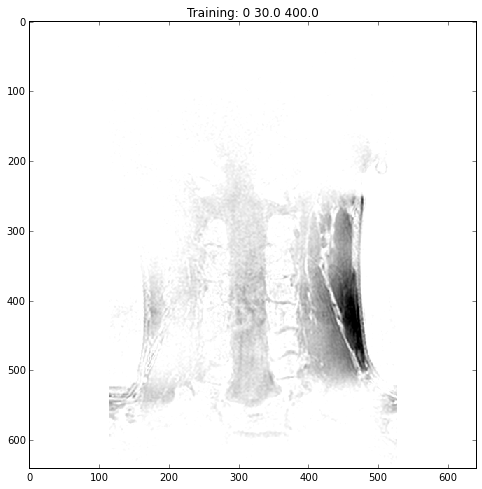

In [11]:
browse_images(image_array)